## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV

In [2]:
img = np.load('sign-language-digits-dataset/X.npy')
label = np.load('sign-language-digits-dataset/Y.npy')
label_class = [ np.where(r==1)[0][0] for r in label ]

In [3]:
img_shape = (64,64)

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    #assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if (i >= len(images)):
          break
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

0


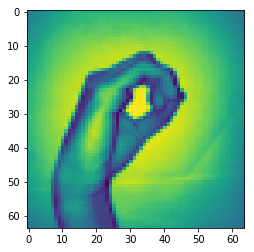

1


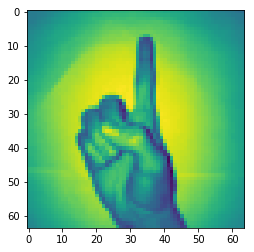

2


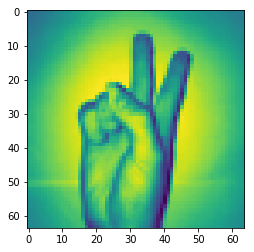

3


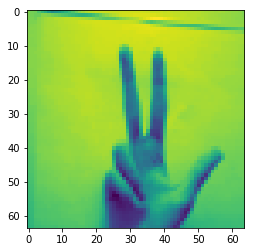

4


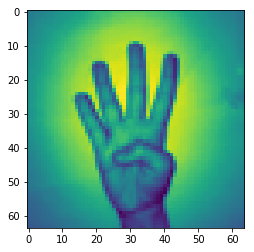

5


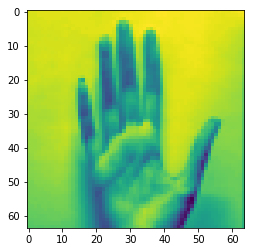

6


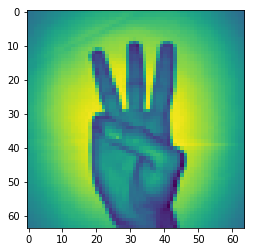

7


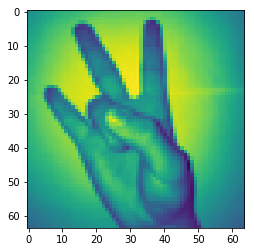

8


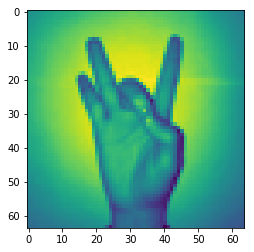

9


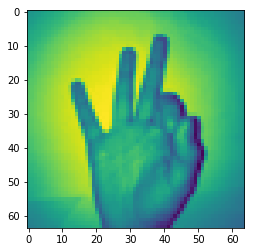

In [5]:
image_index_list = [260,900,1800,1600,1400,2061,700,500,1111,100]


digit_dict = [9, 0, 7, 6, 1, 8, 4, 3, 2, 5]

for i in image_index_list:
  plt.imshow(img[i])
  print(digit_dict[label_class[i]])
  plt.show()

# Tensorflow CNN

## Placeholders

In [20]:
x = tf.placeholder(tf.float32, shape=[None, 64,64], name='X')
x_image = tf.reshape(x, [-1, 64, 64, 1])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Define Layers

In [21]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name,stride=[1, 1, 1, 1]):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=stride, padding='SAME')
        layer += biases
        
        return layer, weights

In [22]:
def new_pool_layer(input,name,stride=[1,2,2,1],ksize=[1,2,2,1]):
  with tf.variable_scope(name) as scope:
    layer = tf.nn.max_pool(input,strides=[1,2,2,1],ksize=[1,2,2,1],padding='SAME')
    return layer

In [23]:
def new_relu_layer(input,name):
  with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

In [24]:
def new_fc_layer(input, num_inputs, num_outputs, name):
  with tf.variable_scope(name) as scope:
      weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
      biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

      layer = tf.matmul(input, weights) + biases
      return layer

## Model Architecture

Conv layer -> Pool layer -> Relu layer -> Conv layer -> Pool layer -> Relu layer -> Conv layer -> Pool layer -> Relu layer -> Flatten -> Fully connected1 -> Batch norm -> Fully connected2

In [25]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=1, filter_size=3, num_filters=6, name ="conv1")
layer_pool1 = new_pool_layer(layer_conv1,'pool1')
layer_relu1 = new_relu_layer(layer_pool1,'relu1')

layer_conv2, weights_conv2 = new_conv_layer(input=layer_relu1, num_input_channels=6, filter_size=3, num_filters=32, name ="conv2")
layer_pool2 = new_pool_layer(layer_conv2,'pool2')
layer_relu2 = new_relu_layer(layer_pool2,'relu2')

layer_conv3, weights_conv3 = new_conv_layer(input=layer_relu2, num_input_channels=32, filter_size=3, num_filters=64, name ="conv3")
layer_pool3 = new_pool_layer(layer_conv3,'pool3')
layer_relu3 = new_relu_layer(layer_pool3,'relu3')

num_features = layer_relu3.get_shape()[1:4].num_elements()
layer_flat = tf.reshape(layer_relu3, [-1, num_features])
layer_fc1 = new_fc_layer(layer_flat, num_inputs=num_features, num_outputs=128,name='fc1')

layer_bn = tf.contrib.layers.batch_norm(layer_fc1 ,center=True, scale=True)
layer_relu4 = new_relu_layer(layer_bn, name="relu3")
layer_fc2 = new_fc_layer(input=layer_relu4, num_inputs=128, num_outputs=10, name="fc2")

with tf.variable_scope('softmax'):
  y_pred = tf.nn.softmax(layer_fc2)
  y_pred_cls = tf.argmax(y_pred, axis=1)
  
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

with tf.name_scope('opt'):
  optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Helper Functions

In [26]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = val_y
    cls_true = [ np.where(r==1)[0][0] for r in cls_true ]

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [27]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(val_x)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = val_x[i:j, :]

        # Get the associated labels.
        labels = val_y[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = val_y
    cls_true = [ np.where(r==1)[0][0] for r in cls_true ]
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [28]:

def  plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = val_x[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = val_y[incorrect]
    cls_true = [ np.where(r==1)[0][0] for r in cls_true ]
    # Plot the first 9 images.
    num = len(images) if len(images) < 9 else 9
    plot_images(images=images[0:num],
                cls_true=cls_true[0:num],
                cls_pred=cls_pred[0:num])

## Results

In [29]:
def printResult(epoch, numberOfEpoch, trainLoss, validationLoss, validationAccuracy):
    print("Epoch: {}/{}".format(epoch+1, numberOfEpoch),
         '\tTraining Loss: {:.3f}'.format(trainLoss),
         '\tValidation Loss: {:.3f}'.format(validationLoss),
         '\tAccuracy: {:.2f}%'.format(validationAccuracy*100))

Epoch: 1/20 	Training Loss: 1.191 	Validation Loss: 1.196 	Accuracy: 71.19%
Epoch: 2/20 	Training Loss: 0.648 	Validation Loss: 0.715 	Accuracy: 86.68%
Epoch: 3/20 	Training Loss: 0.560 	Validation Loss: 0.572 	Accuracy: 86.68%
Epoch: 4/20 	Training Loss: 0.587 	Validation Loss: 0.424 	Accuracy: 89.83%
Epoch: 5/20 	Training Loss: 0.259 	Validation Loss: 0.335 	Accuracy: 91.77%
Epoch: 6/20 	Training Loss: 0.291 	Validation Loss: 0.278 	Accuracy: 94.67%
Epoch: 7/20 	Training Loss: 0.200 	Validation Loss: 0.170 	Accuracy: 98.55%
Epoch: 8/20 	Training Loss: 0.093 	Validation Loss: 0.164 	Accuracy: 97.82%
Epoch: 9/20 	Training Loss: 0.179 	Validation Loss: 0.120 	Accuracy: 98.79%
Epoch: 10/20 	Training Loss: 0.099 	Validation Loss: 0.089 	Accuracy: 100.00%
Accuracy on Test-Set: 99.5% (411 / 413)
Example errors:


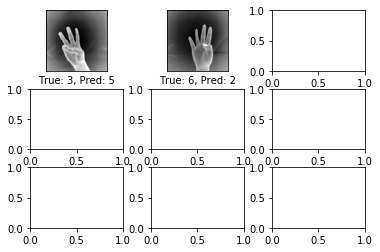

Confusion Matrix:
[[32  0  0  0  0  0  0  0  0  0]
 [ 0 45  0  0  0  0  0  0  0  0]
 [ 0  0 46  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 37  0  0  0  0  0]
 [ 0  0  0  0  0 44  0  0  0  0]
 [ 0  0  1  0  0  0 49  0  0  0]
 [ 0  0  0  0  0  0  0 37  0  0]
 [ 0  0  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  0  0  0  0 47]]


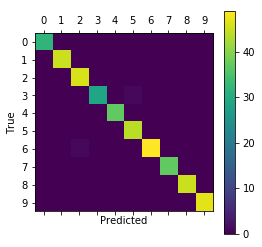

Epoch: 11/20 	Training Loss: 0.054 	Validation Loss: 0.077 	Accuracy: 99.27%
Epoch: 12/20 	Training Loss: 0.113 	Validation Loss: 0.067 	Accuracy: 99.27%
Epoch: 13/20 	Training Loss: 0.068 	Validation Loss: 0.056 	Accuracy: 99.52%
Epoch: 14/20 	Training Loss: 0.062 	Validation Loss: 0.036 	Accuracy: 100.00%
Epoch: 15/20 	Training Loss: 0.037 	Validation Loss: 0.030 	Accuracy: 100.00%
Epoch: 16/20 	Training Loss: 0.029 	Validation Loss: 0.030 	Accuracy: 100.00%
Epoch: 17/20 	Training Loss: 0.024 	Validation Loss: 0.023 	Accuracy: 100.00%
Epoch: 18/20 	Training Loss: 0.025 	Validation Loss: 0.019 	Accuracy: 99.76%
Epoch: 19/20 	Training Loss: 0.055 	Validation Loss: 0.017 	Accuracy: 100.00%
Epoch: 20/20 	Training Loss: 0.015 	Validation Loss: 0.014 	Accuracy: 100.00%
Accuracy on Test-Set: 100.0% (413 / 413)
Example errors:


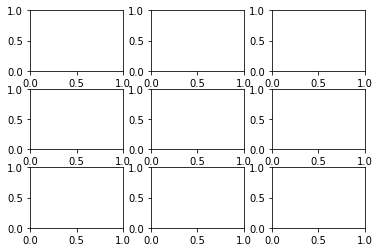

Confusion Matrix:
[[46  0  0  0  0  0  0  0  0  0]
 [ 0 41  0  0  0  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  0]
 [ 0  0  0 41  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 42  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0]
 [ 0  0  0  0  0  0  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 44]]


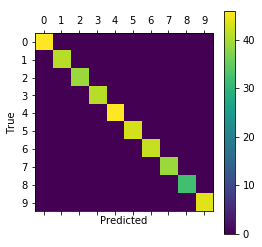

Time elapsed:  4.6021433499532804


In [30]:
import timeit
start_time = timeit.default_timer()
num_epochs = 20
batchSize = 100


with tf.Session () as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(num_epochs):
        train_x, val_x, train_y, val_y = train_test_split(img, label, test_size = 0.2)
        
        
        for i in range(0, len(train_x), 100):
            trainLoss, _= sess.run([cost, optimizer], feed_dict = {
                x: train_x[i: i+batchSize],
                y_true: train_y[i: i+batchSize]
            })
        if (epoch % 10 == 0) and epoch != 0:
            print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)

        valAcc, valLoss = sess.run([accuracy, cost], feed_dict ={
            x: val_x,
            y_true: val_y,})
        
        printResult(epoch, num_epochs, trainLoss, valLoss, valAcc)
    print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)
elapsed = timeit.default_timer() - start_time
print('Time elapsed: ',elapsed)

# TensorFlow AlexNet

## Placeholders

In [17]:
x = tf.placeholder(tf.float32, shape=[None, 64,64], name='X')

x_image = tf.reshape(x, [-1, 64, 64, 1])

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Model Architecture

In [18]:
layer, weights = new_conv_layer(input=x_image, num_input_channels=1, filter_size=3, num_filters=96, name ="conv1",stride=[1,4,4,1])
layer = new_relu_layer(layer,'relu1')

layer, weights = new_conv_layer(input=layer, num_input_channels=96, filter_size=3, num_filters=96, name ="conv1",stride=[1,2,2,1])
layer = new_relu_layer(layer,'relu1')

layer = new_pool_layer(layer,'pool1',)

#batch norm
layer, weights = new_conv_layer(input=layer, num_input_channels=96, filter_size=5, num_filters=256, name ="conv1")
layer = new_relu_layer(layer,'relu1')
layer = new_pool_layer(layer,'pool1',ksize=[1,3,3,1])
#BAtch norm
layer = tf.contrib.layers.batch_norm(layer ,center=True, scale=True)

layer, weights = new_conv_layer(input=layer, num_input_channels=256, filter_size=5, num_filters=384, name ="conv1",)
layer =new_relu_layer(layer,'relu1')

layer ,weights= new_conv_layer(input=layer, num_input_channels=384, filter_size=5, num_filters=384, name ="conv1",)
layer  =new_relu_layer(layer,'relu1')

layer, weights = new_conv_layer(input=layer, num_input_channels=384, filter_size=5, num_filters=256, name ="conv1")
layer =new_relu_layer(layer,'relu1')
layer = new_pool_layer(layer,'pool1',ksize=[1,3,3,1])
#batch norm
layer = tf.contrib.layers.batch_norm(layer ,center=True, scale=True)

num_features = layer.get_shape()[1:4].num_elements()
layer= tf.reshape(layer, [-1, num_features])

layer= new_fc_layer(layer, num_inputs=num_features, num_outputs=4096,name='fc1')

layer = tf.layers.dropout(layer,rate=0.5)

layer= new_relu_layer(layer, name="relu3")

layer = new_fc_layer(input=layer, num_inputs=4096, num_outputs=4096, name="fc2")
layer = tf.layers.dropout(layer,rate=0.5)

layer = new_fc_layer(input=layer, num_inputs=4096, num_outputs=10, name="fc2")

with tf.variable_scope('softmax'):
  y_pred = tf.nn.softmax(layer)
  y_pred_cls = tf.argmax(y_pred, axis=1)
  
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

with tf.name_scope('opt'):
  optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Results

Epoch: 1/20 	Training Loss: 8.274 	Validation Loss: 8.741 	Accuracy: 45.76%
Epoch: 2/20 	Training Loss: 6.104 	Validation Loss: 5.566 	Accuracy: 53.75%
Epoch: 3/20 	Training Loss: 3.204 	Validation Loss: 2.799 	Accuracy: 65.62%
Epoch: 4/20 	Training Loss: 0.849 	Validation Loss: 2.063 	Accuracy: 72.88%
Epoch: 5/20 	Training Loss: 1.596 	Validation Loss: 1.198 	Accuracy: 81.11%
Epoch: 6/20 	Training Loss: 1.125 	Validation Loss: 1.166 	Accuracy: 79.90%
Epoch: 7/20 	Training Loss: 0.714 	Validation Loss: 0.631 	Accuracy: 88.62%
Epoch: 8/20 	Training Loss: 0.802 	Validation Loss: 0.930 	Accuracy: 83.05%
Epoch: 9/20 	Training Loss: 1.274 	Validation Loss: 0.446 	Accuracy: 90.31%
Epoch: 10/20 	Training Loss: 1.055 	Validation Loss: 0.383 	Accuracy: 89.10%
Accuracy on Test-Set: 88.1% (364 / 413)
Example errors:


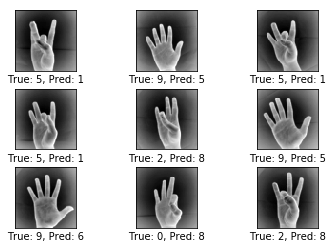

Confusion Matrix:
[[36  0  0  0  0  0  0  0  1  0]
 [ 1 43  0  0  0  0  0  0  0  0]
 [ 2  0 29  3  0  0  1  0  8  0]
 [ 0  0  0 32  0  1  0  1  2  0]
 [ 1  3  0  0 39  0  0  0  1  0]
 [ 0  4  3  0  0 30  0  0  2  0]
 [ 0  0  0  4  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 39  0  0]
 [ 0  0  0  0  0  0  0  2 38  0]
 [ 1  0  0  0  0  3  4  1  0 43]]


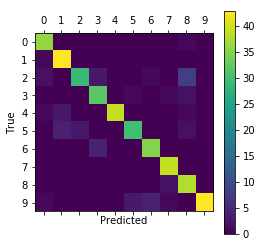

Epoch: 11/20 	Training Loss: 0.320 	Validation Loss: 0.544 	Accuracy: 89.10%
Epoch: 12/20 	Training Loss: 0.879 	Validation Loss: 0.316 	Accuracy: 93.22%
Epoch: 13/20 	Training Loss: 0.519 	Validation Loss: 0.509 	Accuracy: 89.59%
Epoch: 14/20 	Training Loss: 0.748 	Validation Loss: 0.391 	Accuracy: 92.98%
Epoch: 15/20 	Training Loss: 0.204 	Validation Loss: 0.237 	Accuracy: 95.64%
Epoch: 16/20 	Training Loss: 0.240 	Validation Loss: 0.166 	Accuracy: 95.40%
Epoch: 17/20 	Training Loss: 0.103 	Validation Loss: 0.241 	Accuracy: 93.70%
Epoch: 18/20 	Training Loss: 0.221 	Validation Loss: 0.248 	Accuracy: 91.77%
Epoch: 19/20 	Training Loss: 0.268 	Validation Loss: 0.089 	Accuracy: 97.34%
Epoch: 20/20 	Training Loss: 0.174 	Validation Loss: 0.100 	Accuracy: 96.37%
Accuracy on Test-Set: 96.1% (397 / 413)
Example errors:


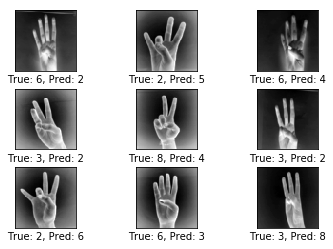

Confusion Matrix:
[[34  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 37  0  0  3  1  0  0  0]
 [ 0  0  3 33  0  0  0  1  1  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0]
 [ 0  0  1  2  1  1 52  0  0  0]
 [ 0  0  0  0  0  0  0 52  0  0]
 [ 0  0  0  0  1  0  0  0 39  0]
 [ 1  0  0  0  0  0  0  0  0 38]]


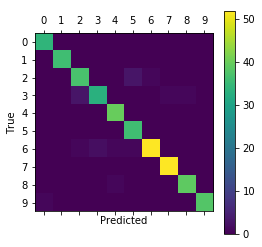

Time elapsed:  14.514901883085571


In [19]:
import timeit
start_time = timeit.default_timer()
num_epochs = 20
batchSize = 100

with tf.Session () as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(num_epochs):
        # training data & validation data
        train_x, val_x, train_y, val_y = train_test_split(img, label,\
                                                      test_size = 0.2)   
        # training loss
        for i in range(0, len(train_x), 100):
            trainLoss, _= sess.run([cost, optimizer], feed_dict = {
                x: train_x[i: i+batchSize],
                y_true: train_y[i: i+batchSize]
            })
        if (epoch % 10 == 0) and epoch != 0:
            print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)    
        # validation loss
        valAcc, valLoss = sess.run([accuracy, cost], feed_dict ={
            x: val_x,
            y_true: val_y,})
        
        
        # print out
        printResult(epoch, num_epochs, trainLoss, valLoss, valAcc)
    print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)    
        
elapsed = timeit.default_timer() - start_time
print('Time elapsed: ',elapsed)

# TensorFlow SqueezeNet

## Define squeeze

In [31]:
def fire(inputs,squeezeTo,expandTo):
    h = squeeze(inputs,squeezeTo)
    h = expand(h,expandTo)
    h = tf.clip_by_norm(h,NORM) # Very important
    activations.append(h)

def squeeze(inputs,squeezeTo):
    with tf.name_scope('squeeze'):
        inputSize = inputs.get_shape().as_list()[3]
        w = tf.Variable(tf.truncated_normal([1,1,inputSize,squeezeTo]))
        h = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))        
    return h

def expand(inputs,expandTo):
    with tf.name_scope('expand'):
        squeezeTo = inputs.get_shape().as_list()[3]
        w = tf.Variable(tf.truncated_normal([1,1,squeezeTo,expandTo]))
        h1x1 = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))
        w = tf.Variable(tf.truncated_normal([3,3,squeezeTo,expandTo]))
        h3x3 = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))
        h = tf.concat([h1x1,h3x3],3)
    return h

## Placeholders

In [32]:
x = tf.placeholder(tf.float32, shape=[None, 64,64], name='X')

x_image = tf.reshape(x, [-1, 64, 64, 1])

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Model Architecture

In [33]:
layer, weights = new_conv_layer(input=x_image, num_input_channels=1, filter_size=3, num_filters=96, name ="conv1",stride=[1,4,4,1])
layer  =new_relu_layer(layer,'relu1')

layer, weights = new_conv_layer(input=layer, num_input_channels=96, filter_size=3, num_filters=96, name ="conv1",stride=[1,2,2,1])
layer  =new_relu_layer(layer,'relu1')

layer = new_pool_layer(layer,'pool1',)

# Squeeze layer
h = squeeze(layer,16)
layer = expand(h,64)


fire_squeeze, weights = new_conv_layer(input=layer, num_input_channels=128, filter_size=1, num_filters=128, name ="conv1",stride=[1,1,1,1])
fire_squeeze  = new_relu_layer(fire_squeeze,'relu1')

fire_expand1, weights = new_conv_layer(input=fire_squeeze, num_input_channels=128, filter_size=3, num_filters=64, name ="conv1",stride=[1,1,1,1])
fire_expand1  = new_relu_layer(fire_expand1,'relu3')
"""
fire_expand2, weights = new_conv_layer(input=fire_squeeze, num_input_channels=16, filter_size=1, num_filters=64, name ="conv1",stride=[1,1,1,1])
fire_expand2  = new_relu_layer(fire_expand2,'relu4')


layer, weights = tf.concat([fire_expand1, fire_expand2],axis=0)
"""

#batch norm
layer, weights = new_conv_layer(input=fire_expand1, num_input_channels=64, filter_size=5, num_filters=256, name ="conv1")
layer =new_relu_layer(layer,'relu1')
layer = new_pool_layer(layer,'pool1',ksize=[1,3,3,1])
#BAtch norm
layer = tf.contrib.layers.batch_norm(layer ,center=True, scale=True)



layer, weights = new_conv_layer(input=layer, num_input_channels=256, filter_size=5, num_filters=384, name ="conv1",)
layer =new_relu_layer(layer,'relu1')

layer ,weights= new_conv_layer(input=layer, num_input_channels=384, filter_size=5, num_filters=384, name ="conv1",)
layer  =new_relu_layer(layer,'relu1')

layer, weights = new_conv_layer(input=layer, num_input_channels=384, filter_size=5, num_filters=256, name ="conv1")
layer =new_relu_layer(layer,'relu1')
layer = new_pool_layer(layer,'pool1',ksize=[1,3,3,1])
#batch norm
layer = tf.contrib.layers.batch_norm(layer ,center=True, scale=True)


num_features = layer.get_shape()[1:4].num_elements()
layer= tf.reshape(layer, [-1, num_features])

layer= new_fc_layer(layer, num_inputs=num_features, num_outputs=4096,name='fc1')

layer = tf.layers.dropout(layer,rate=0.5)

layer= new_relu_layer(layer, name="relu3")

layer = new_fc_layer(input=layer, num_inputs=4096, num_outputs=4096, name="fc2")
layer = tf.layers.dropout(layer,rate=0.5)

layer = new_fc_layer(input=layer, num_inputs=4096, num_outputs=10, name="fc2")
#layer = tf.layers.dropout(layer,rate=0.5)

#layer = new_fc_layer(input=layer, num_inputs=128, num_outputs=10, name="fc2")

with tf.variable_scope('softmax'):
  y_pred = tf.nn.softmax(layer)
  y_pred_cls = tf.argmax(y_pred, axis=1)
  
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

with tf.name_scope('opt'):
  optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


## Results

Epoch: 1/20 	Training Loss: 11.683 	Validation Loss: 13.562 	Accuracy: 31.96%
Epoch: 2/20 	Training Loss: 4.302 	Validation Loss: 5.731 	Accuracy: 44.31%
Epoch: 3/20 	Training Loss: 3.632 	Validation Loss: 3.637 	Accuracy: 46.25%
Epoch: 4/20 	Training Loss: 1.951 	Validation Loss: 2.769 	Accuracy: 53.27%
Epoch: 5/20 	Training Loss: 1.387 	Validation Loss: 1.794 	Accuracy: 59.81%
Epoch: 6/20 	Training Loss: 2.795 	Validation Loss: 2.261 	Accuracy: 59.08%
Epoch: 7/20 	Training Loss: 2.253 	Validation Loss: 1.378 	Accuracy: 67.31%
Epoch: 8/20 	Training Loss: 1.818 	Validation Loss: 1.050 	Accuracy: 72.88%
Epoch: 9/20 	Training Loss: 1.048 	Validation Loss: 0.927 	Accuracy: 77.00%
Epoch: 10/20 	Training Loss: 0.888 	Validation Loss: 0.944 	Accuracy: 82.08%
Accuracy on Test-Set: 82.6% (341 / 413)
Example errors:


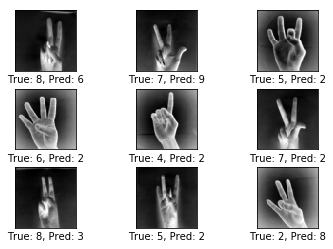

Confusion Matrix:
[[32  3  0  1  0  4  0  1  0  1]
 [ 0 36  1  0  0  1  1  0  0  0]
 [ 0  1 39  0  0  1  0  0  2  0]
 [ 0  0  4 28  0  0  3  0  0  0]
 [ 0  1  1  0 36  0  0  1  1  0]
 [ 0  2 18  0  1 27  0  0  0  0]
 [ 0  1  3  1  0  2 29  0  0  0]
 [ 1  0  1  0  0  0  0 32  0  3]
 [ 0  0  4  1  0  0  1  2 38  0]
 [ 1  0  0  0  0  0  2  0  0 44]]


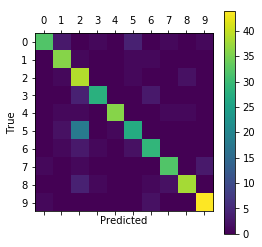

Epoch: 11/20 	Training Loss: 0.942 	Validation Loss: 0.704 	Accuracy: 80.87%
Epoch: 12/20 	Training Loss: 1.117 	Validation Loss: 0.864 	Accuracy: 81.60%
Epoch: 13/20 	Training Loss: 0.965 	Validation Loss: 0.582 	Accuracy: 82.81%
Epoch: 14/20 	Training Loss: 0.337 	Validation Loss: 0.713 	Accuracy: 82.81%
Epoch: 15/20 	Training Loss: 0.229 	Validation Loss: 0.634 	Accuracy: 82.57%
Epoch: 16/20 	Training Loss: 0.387 	Validation Loss: 0.540 	Accuracy: 87.89%
Epoch: 17/20 	Training Loss: 0.472 	Validation Loss: 0.364 	Accuracy: 88.86%
Epoch: 18/20 	Training Loss: 0.527 	Validation Loss: 0.259 	Accuracy: 91.77%
Epoch: 19/20 	Training Loss: 0.688 	Validation Loss: 0.572 	Accuracy: 86.92%
Epoch: 20/20 	Training Loss: 0.093 	Validation Loss: 0.684 	Accuracy: 84.99%
Accuracy on Test-Set: 84.7% (350 / 413)
Example errors:


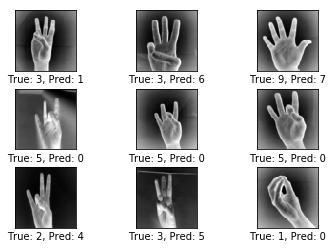

Confusion Matrix:
[[42  0  0  0  0  1  0  0  0  0]
 [ 1 43  0  0  0  1  0  1  0  0]
 [ 1  3 37  0  4  2  0  0  1  0]
 [ 3  1  3 23  0  2  9  0  1  0]
 [ 0  0  0  0 33  0  0  0  0  0]
 [10  0  2  0  0 32  0  0  0  0]
 [ 4  0  0  1  0  0 30  0  0  1]
 [ 0  0  0  0  0  0  0 34  1  0]
 [ 0  0  1  0  5  0  0  0 30  0]
 [ 2  0  0  0  0  0  0  2  0 46]]


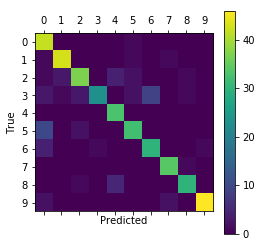

Time elapsed:  14.253329127040331


In [34]:
import timeit
start_time = timeit.default_timer()
num_epochs = 20
batchSize = 100

with tf.Session () as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(num_epochs):
        # training data & validation data
        train_x, val_x, train_y, val_y = train_test_split(img, label,\
                                                      test_size = 0.2)   
        # training loss
        for i in range(0, len(train_x), 100):
            trainLoss, _= sess.run([cost, optimizer], feed_dict = {
                x: train_x[i: i+batchSize],
                y_true: train_y[i: i+batchSize]
            })
            
        if (epoch % 10 == 0) and epoch != 0:
            print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)    
        # validation loss
        valAcc, valLoss = sess.run([accuracy, cost], feed_dict ={
            x: val_x,
            y_true: val_y,})
        
        
        # print out
        printResult(epoch, num_epochs, trainLoss, valLoss, valAcc)
    print_test_accuracy(show_confusion_matrix=True, show_example_errors=True)  
elapsed = timeit.default_timer() - start_time
print('Time elapsed: ',elapsed)

# PCA Dimension Reductionality

## Find PCA Components

In [35]:
new_img = np.array(img).reshape((2062, 64*64))
print (new_img.shape)

pca_dims = PCA()
pca_dims.fit(new_img)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print (d)

pca = PCA(n_components=d)

(2062, 4096)
316


## Placeholders

In [36]:
x = tf.placeholder(tf.float32, shape=[None, d], name='X')
x_image = tf.reshape(x, [-1, d, 1, 1])

y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Define Layers

In [37]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, name,stride=[1, 1, 1, 1]):
    with tf.variable_scope(name) as scope:
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        layer = tf.nn.conv2d(input=input, filter=weights, strides=stride, padding='SAME')
        layer += biases
        
        return layer, weights

In [38]:
def new_pool_layer(input,name,stride=[1,2,2,1],ksize=[1,2,2,1]):
  with tf.variable_scope(name) as scope:
    layer = tf.nn.max_pool(input,strides=stride,ksize=ksize,padding='SAME')
    return layer

In [39]:
def new_relu_layer(input,name):
  with tf.variable_scope(name) as scope:
        layer = tf.nn.relu(input)
        return layer

In [40]:
def new_fc_layer(input, num_inputs, num_outputs, name):
  with tf.variable_scope(name) as scope:
      weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
      biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

      layer = tf.matmul(input, weights) + biases
      return layer

## Model Architecture

In [41]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=1, filter_size=3, num_filters=6, name ="conv1")
layer_pool1 = new_pool_layer(layer_conv1,'pool1')
layer_relu1 = new_relu_layer(layer_pool1,'relu1')

layer_conv2, weights_conv2 = new_conv_layer(input=layer_relu1, num_input_channels=6, filter_size=3, num_filters=32, name ="conv2")
layer_pool2 = new_pool_layer(layer_conv2,'pool2')
layer_relu2 = new_relu_layer(layer_pool2,'relu2')

layer_conv3, weights_conv3 = new_conv_layer(input=layer_relu2, num_input_channels=32, filter_size=3, num_filters=64, name ="conv3")
layer_pool3 = new_pool_layer(layer_conv3,'pool3')
layer_relu3 = new_relu_layer(layer_pool3,'relu3')

num_features = layer_relu3.get_shape()[1:4].num_elements()
layer_flat = tf.reshape(layer_relu3, [-1, num_features])
layer_fc1 = new_fc_layer(layer_flat, num_inputs=num_features, num_outputs=128,name='fc1')

layer_bn = tf.contrib.layers.batch_norm(layer_fc1 ,center=True, scale=True)
layer_relu4 = new_relu_layer(layer_bn, name="relu3")
layer_fc2 = new_fc_layer(input=layer_relu4, num_inputs=128, num_outputs=10, name="fc2")

with tf.variable_scope('softmax'):
  y_pred = tf.nn.softmax(layer_fc2)
  y_pred_cls = tf.argmax(y_pred, axis=1)
  
with tf.name_scope("cross_ent"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)
    cost = tf.reduce_mean(cross_entropy)

with tf.name_scope('opt'):
  optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Results

In [42]:
def printResult(epoch, numberOfEpoch, trainLoss, validationLoss, validationAccuracy):
    print("Epoch: {}/{}".format(epoch+1, numberOfEpoch),
         '\tTraining Loss: {:.3f}'.format(trainLoss),
         '\tValidation Loss: {:.3f}'.format(validationLoss),
         '\tAccuracy: {:.2f}%'.format(validationAccuracy*100))

In [43]:
num_epochs = 20
batchSize = 100

with tf.Session () as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(num_epochs):
      
        train_x, val_x, train_y, val_y = train_test_split(new_img, label, test_size = 0.2)
        train_x = pca.fit_transform(train_x)
        val_x   = pca.fit_transform(val_x)
      
        # training loss
        for i in range(0, len(train_x), 100):
            trainLoss, _= sess.run([cost, optimizer], feed_dict = {
                x: train_x[i: i+batchSize],
                y_true: train_y[i: i+batchSize]
            })
            
        # validation loss
        valAcc, valLoss = sess.run([accuracy, cost], feed_dict ={
            x: val_x,
            y_true: val_y,})
        
        
        # print out
        printResult(epoch, num_epochs, trainLoss, valLoss, valAcc)

Epoch: 1/20 	Training Loss: 2.215 	Validation Loss: 2.259 	Accuracy: 13.32%
Epoch: 2/20 	Training Loss: 2.007 	Validation Loss: 2.158 	Accuracy: 19.85%
Epoch: 3/20 	Training Loss: 1.806 	Validation Loss: 2.202 	Accuracy: 17.19%
Epoch: 4/20 	Training Loss: 1.696 	Validation Loss: 2.032 	Accuracy: 26.63%
Epoch: 5/20 	Training Loss: 1.424 	Validation Loss: 2.469 	Accuracy: 17.19%
Epoch: 6/20 	Training Loss: 1.546 	Validation Loss: 2.232 	Accuracy: 27.60%
Epoch: 7/20 	Training Loss: 1.365 	Validation Loss: 2.267 	Accuracy: 21.07%
Epoch: 8/20 	Training Loss: 1.427 	Validation Loss: 2.321 	Accuracy: 20.82%
Epoch: 9/20 	Training Loss: 1.288 	Validation Loss: 3.160 	Accuracy: 12.35%
Epoch: 10/20 	Training Loss: 1.649 	Validation Loss: 2.473 	Accuracy: 20.34%
Epoch: 11/20 	Training Loss: 1.457 	Validation Loss: 2.314 	Accuracy: 22.28%
Epoch: 12/20 	Training Loss: 1.516 	Validation Loss: 2.146 	Accuracy: 25.18%
Epoch: 13/20 	Training Loss: 1.341 	Validation Loss: 2.169 	Accuracy: 25.91%
Epoch: 1